## K-means Clustering

In this exercise, you will implement K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

#### Importing libraries

In [2]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# Tells matplotlib to embed plots within the notebook
%matplotlib inline

### Implementing K-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, we are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning the training examples to their closest centroids and then recomputing the centroids based on these assignments.

The K-means algorithm has the following procedure:

1. Random initialization of cluster centroids
1. Repeat:
    - Cluster assignment step
    - Move centroid step

The inner-loop of the algorithm repeatedly carries out two steps: (1) Assigning each training example $x^{(i)}$ to its closest centroid and (2) Recomputing the mean of each centroid using the data points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. 

**Note**: The converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

#### Random initialization 

To initialize the centroids we should select random examples from the training set. To do this, I will randomly permute the indices of the training examples and select the first $K$ examples based on this random permutation. This allows the examples to be selected at random without the risk of selecting the same example twice.

In [3]:
def randomInitialization(x, K):
    # Number of training examples
    m = x.shape[0]

    # Randomly reorder the indices of examples
    random_indices = np.random.permutation(m)
    
    # Take the first K examples as centroids
    centroids = x[random_indices[:K], :]

    return centroids

#### Cluster assignment step

In the cluster assignment step of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of the centroids. Specifically, for every example $i$ we set

$$c^{(i)} := j \quad \text{that minimizes} \quad \lvert\rvert x^{(i)} - \mu_j  \lvert\rvert^2, $$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j^{th}$ centroid.

To execute this step I will write the function `findClosestCentroids` which takes the data matrix $x$ and the locations of all the centroids inside the variable `centroids` and outputs a one-dimensional array `idx` that holds the index (a value in $\{1, ..., K\}$, where $K$ is total number of centroids) of the closest centroid to every training example.

In [4]:
def clusterAssignment(x, K, centroids):
    # Set K - number of centroids/clusters
    K = centroids.shape[0]
    
    # Set number of training examples
    m = x.shape[0]
    
    # Initializing variable to be used below - dtype is to ensure that the values are integers
    idx = np.zeros(m, dtype=int)

    for i in range(m):
        # Find the lowest distance between the training example and each of the centroids
        idx[i] = np.argmin((np.sqrt(np.sum((x[i] - centroids)**2, axis=1))))
    
    return idx

#### Move centroid step

After having assigned every training example to a centroid, we run the move centroid step of the algorithm. This step computes, for each centroid, the mean of the data points that were assigned to it and moves the centroid to that position.

For every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then we should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.

To do this I will write the function `moveCentroid`.

In [5]:
def moveCentroid(x, idx, K):
    # Number of training examples and number of features, respectively
    m, n = x.shape
    
    # Initializing variable to be used below
    centroids = np.zeros((K, n))

    for i in range(K): # For each of the centroids
        centroids[i] = np.mean(x[idx == i], axis=0)
    
    return centroids

#### K-means algorithm

To plot the clusters and the position of the centroids after running the K-Means algorithm, I will use the function `plotData`.

In [6]:
def plotData(x, K, idx, centroid_history):
    cmap = plt.cm.rainbow # Color palette for the clusters
    norm = mpl.colors.Normalize(vmin=0, vmax=2) # Normalizes values to range [0.0 - 2.0]
    
    for k in range(K):
        cluster = x[idx == k]
        plt.plot(cluster[:, 0], cluster[:, 1],
                 mfc=cmap(norm(k)), 
                 mec=cmap(norm(k)), 
                 linestyle='None', 
                 marker='o', 
                 label=f'Cluster {k + 1}')
        plt.legend()
        
        # Get first centroid values for each iteration of K-Means and stack them in rows
        # Do the same for other centroids
        centroid = np.stack([centroid[k, :] for centroid in centroid_history], axis=0)
        
        plt.plot(centroid[:,0], centroid[:,1],
                 '-Xk',
                 mec='k',
                 lw=2,
                 ms=10,
                 mfc=cmap(norm(k)),
                 mew=2)

Finally, I will put everything together in the function `K_means` which will execute the k-means algorithm on any given dataset and plot the data.

In [7]:
def K_means(x, K, randomInitialization, clusterAssignment, moveCentroid, max_iters, plot=True):
    
    # Initial centroid positions
    centroids = randomInitialization(x, K)
    
    centroid_history = [] # This variable stores the position of the centroids in order to plot the centroids over the data
    centroid_history.append(centroids) # Appending initial centroid positions
    
    for i in range(max_iters):
        idx = clusterAssignment(x, K, centroids)
        centroids = moveCentroid(x, idx, K)
        
        centroid_history.append(centroids)
    
    if plot:
        plotData(x, K, idx, centroid_history)
    
    return centroids, idx

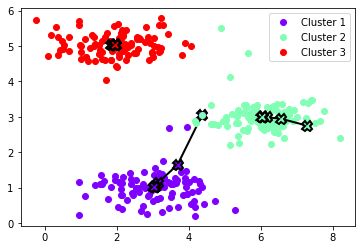

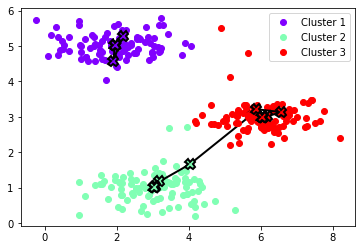

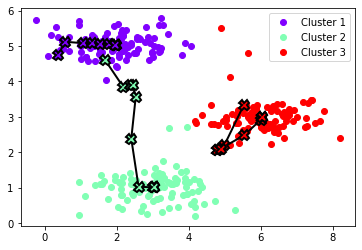

In [8]:
# Load example 2D dataset
data = loadmat('Data/ex7data2.mat')
x = data['X']

# Settings for running K-Means
K = 3 # Number of centroids/clusters
max_iters = 10 

# Run K-Means 3 times to see how random initialization affects the clustering
for i in range(3):
    centroids, idx = K_means(x, K, randomInitialization, clusterAssignment, moveCentroid, max_iters)
    plt.show()

### Image compression using K-means

Now I will apply K-means to image compression. I will use the image below as an example.

![](Data/bird_small.png)

In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is referred to as RGB encoding. This image contains thousands of colors and the goal is to reduce the total number of colors to 16 colors (only 4 bits are necessary to represent 16 possibilities).

By making this reduction, it is possible to represent (compress) the image in an efficient way. I will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, I will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once I have computed the cluster centroids on the image, I will then use the 16 colors to replace the pixels in the original image.

**Note**: I have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128 x 128 pixel locations, resulting in total size of 128 x 128 x 24 = 393,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 x 24 + 128 x 128 x 4 = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

Text(0.5, 1.0, 'Compressed image with 16 colors')

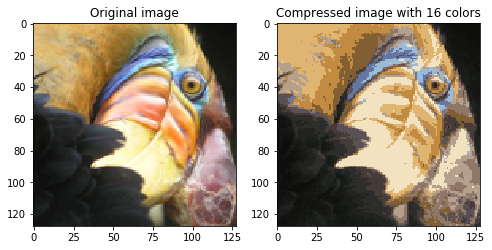

In [9]:
# Settings to run K-Means
K = 16 # number of colors
max_iters = 10

# # Load 128x128 image
A = mpl.image.imread('Data/bird_small.png')
# This creates a three-dimensional matrix `A` (128 x 128 x 3) whose first two indices identify a pixel position and 
# whose last index represents red, green, or blue. For example, A[50, 33, 2] gives the blue intensity of the pixel
# at row 51 and column 34 (A is a zero-indexed matrix)

# RGB values range from 0 to 255. As such I will divide all values by 255 so that all values are in the range [0-1].
# The range [0-1] is used for the .imshow method below.
A /= 255

# Reshape the image into a two-dimensional matrix m x 3, where m = number of pixels (m = 16384 = 128 x 128).
# Each row will contain the Red, Green and Blue pixel values.
# This will be the dataset that we will use K-Means on.
X = A.reshape(-1, 3) # -1 indicates that the maximum number of rows should be filled

# Run K-Means
centroids, idx = K_means(X, K, randomInitialization, clusterAssignment, moveCentroid, max_iters, plot=False)

# The 'centroids' matrix has the 16 colors and the 'idx' matrix has the index of the color that each pixel was assigned to,
# so to recover the compressed image we simply map each pixel (represented by its index in 'idx') to the centroid value
# (color that it was assigned to) and reshape it into proper dimensions in order to be displayed by matplotlib
X_recovered = centroids[idx, :].reshape(A.shape)

# Create plot area
fig, ax = plt.subplots(1, 2, figsize=(8, 4)) # arguments (# of rows, # of columns, size of plots)

# Display the original image, rescale back by 255
ax[0].imshow(A * 255)
ax[0].set_title('Original image')

# Display compressed image, rescale back by 255
ax[1].imshow(X_recovered * 255)
ax[1].set_title(f'Compressed image with {K} colors')